# Etapa 3 del proyecto. La tarea de agrupación: el algoritmo k-medias
**By: Alejandra Ossa Yepes**

En esta última parte del proyecto abordaremos el problema de determinar el patrón de uso de combustibles fósiles de los países para establecer planes de acción que permitan mitigar sus efectos y generar alarmas sobre los niveles de contaminación.

1. Aplicar técnicas de agrupación para construir un modelo descriptivo que permita caracterizar los países según sus niveles de emisiones de CO2 debido al uso de combustibles fósiles. 

2. Determinar cuáles son los factores que más inciden en la contaminación por CO2.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

## 1. Carga de datos


In [2]:
data_raw = pd.read_excel('Datos_Etapa-3.xlsx')

In [3]:
data_raw.head()

,Year,Country,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels
0,2010,AFGHANISTAN,627,1601,74,5,0,0.08,9
1,2010,ALBANIA,117,953,7,177,0,0.43,7
2,2010,ALGERIA,332,12381,14565,2598,2623,0.90,663
3,2010,ANDORRA,0,141,0,0,0,1.68,0
4,2010,ANGOLA,0,3649,374,204,3697,0.37,321


In [4]:
data_raw.shape

(1094, 9)

## 2. Exploración del conjunto de datos

In [5]:
data_raw.describe()

,Year,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels
count,1094.000000,1.094000e+03,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,2012.008227,1.821228e+04,12629.853748,8081.466179,2358.596892,303.155393,1.402322,1397.728519
std,1.413866,1.398963e+05,48137.338515,31756.289140,20519.921472,1215.463120,1.750614,4459.418883
min,2010.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,0.000000e+00,197.750000,0.000000,0.000000,0.000000,0.220000,12.250000
50%,2012.000000,3.000000e+01,1222.000000,13.000000,136.000000,0.000000,0.845000,101.000000
75%,2013.000000,1.502000e+03,6429.750000,3224.500000,634.750000,0.000000,1.830000,617.000000
max,2014.000000,2.045156e+06,590751.000000,390719.000000,338912.000000,9550.000000,13.540000,42215.000000


## 3. Limpieza y preparación de datos


In [6]:
data = data_raw.copy()

In [7]:
data = data.drop(['Year','Country'], axis=1)

Se elimina las columnas `Year` y `Country` las caules son variable poco relevante para realizar la agrupación

In [8]:
data.isna().sum()

Solid Fuel      0
Liquid Fuel     0
Gas Fuel        0
Cement          0
Gas Flaring     0
Per Capita      0
Bunker fuels    0
dtype: int64

Como puedes observar, se tienen datos nulos en las variable

In [9]:
data.duplicated().sum()

32

In [10]:
data = data.drop_duplicates()

In [11]:
data.reset_index(drop = True, inplace=True)

Reseteamos los indexes ya que por cada fila van a haber valores unicos con las caracteristicas respectivas, ademas al tratarse de un algoritmo no supervisado, no realizaremos división de datos al no contar con etiquetas. Por lo tanto

## 4. Estandarización

KMeans calcula distancias entre puntos, por lo que realizaremos una estandarización para que la escala de la variable no tenga influencia sobre las distancias calculadas. Utilizaremos un objeto de la clase `StandardScaler()` que, por cada variable, elimina la media y la escala hasta llegar a una varianza unitaria:

In [12]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
scaler = StandardScaler()

In [13]:
kmeans = KMeans(max_iter=300, random_state=77 )

In [14]:
pipe = Pipeline(steps=[("imputer", imputer), ("scaler", scaler), ("model", kmeans)])

## 5. Método del codo
Busqueda del mejor valor de _k_  mediante el método del codo, definiendo el rango `k: [2, 3, 4, 5]`. Adicionalmente, generará una gráfica con los valores de inercia, es decir, con la suma de los cuadrados de las distancias de todos los puntos al centroide más cercano:

In [32]:
def elbow_plot(data, k_min=2, k_max=5):
    """
    Genera la gráfica para el método del codo
    
    Parametros:
    data : np.array
        El arreglo con los datos
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    inertias = []
    for i in range(k_min, k_max+1):
        # Modificamos el parámetro k
        pipe.set_params(model__n_clusters=i)
        # Ejecutamos el pipeline, entrenando el modelo de KMeans
        pipe.fit(data)
        # Almacenamos el valor de inercia
        inertias.append(pipe['model'].inertia_)
    
    # Graficamos los valores de inercia
    plt.plot(range(k_min,k_max+1), inertias, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Inercia')
    plt.title('Comportamiento de la Inercia vs Número de Clusters')
    plt.grid()
    plt.show()

Con la función construida, veremos el comportamiento para nuestro conjunto de datos:

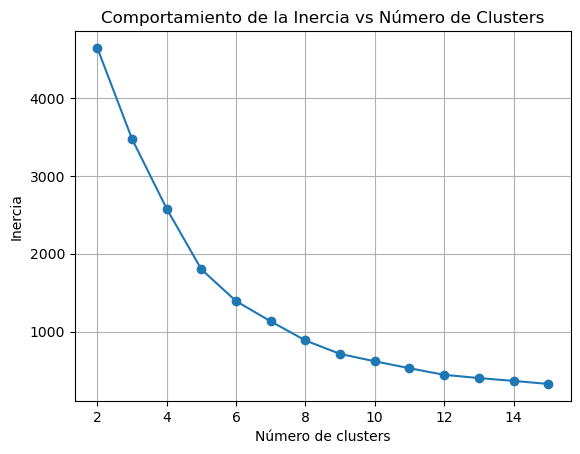

In [33]:
elbow_plot(data, 2, 15)

El mejor valor de _k_ se determina con el punto después del cual la inercia empieza a tener un comportamiento aproximadamente lineal, la función `make_blobs()` ayuda a generar un conjunto de 100 datos descritos por dos variables, con tres grupos fácilmente separables:

Text(0.5, 1.0, 'Conjunto de 100 datos en dos variables con 3 grupos')

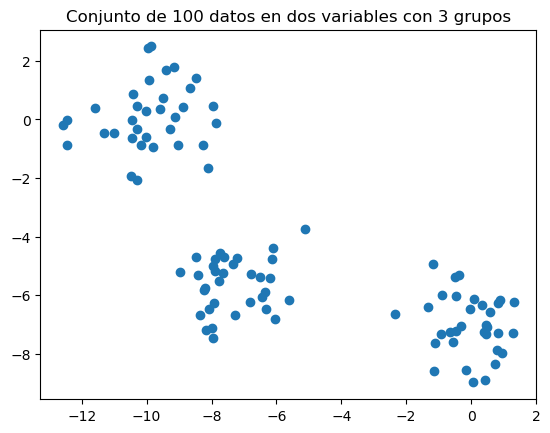

In [17]:
x_blobs, y_blobs = make_blobs(n_samples=100, centers=3, n_features=2, random_state=9)
plt.scatter(x_blobs[:,0], x_blobs[:,1])
plt.title('Conjunto de 100 datos en dos variables con 3 grupos')

Se hace uso de la funcion `make_blobs()` para usar los datos almacenados en `x_blobs` para ejecutar la misma función `elbow_plot()`:

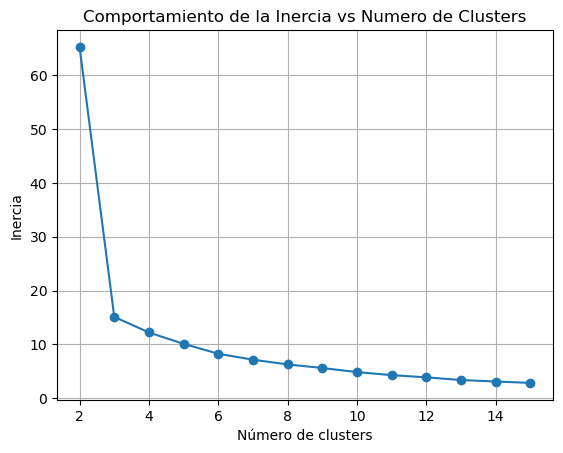

In [18]:
data_blobs = pd.DataFrame(x_blobs)
elbow_plot(data_blobs, 2, 15)

Puedes observar que se presenta un codo claro en `_k_ = 3`, en el que el comportamiento de la función cambia y un aumento de _k_ no representa una disminución considerable en la inercia. Entonces, para este conjunto de datos el mejor `_k_ es 3`, como lo definimos inicialmente.

## 6.Método de la silueta
Mide la separación entre los clusters obtenidos en algoritmos de agrupación. Valores cercanos a 1 indican que un dato está lejos de los demás clusters, mientras que valores cercanos a -1 indican que un dato está más cerca a otro cluster que al que fue asignado.
Utilizaremos la función `silhouette_score()`, que retorna el promedio del coeficiente de la silueta para todos los datos del conjunto. 

In [19]:
def silhouette_plot(data, k_min=2, k_max=5):
    """
    Genera la gráfica con el coeficiente de la silueta
    
    Parametros:
    data : np.array
        El arreglo con los datos
    k_min : int
        Valor mínimo para k
    k_max : int
        Valor máximo para k
    """
    scores = []
    for i in range(k_min, k_max+1):
        # Modificamos el parámetro k
        pipe.set_params(model__n_clusters=i)
        # Ejecutamos el pipeline, entrenando el modelo de KMeans
        pipe.fit(data)
        # Procesamos los datos
        imputer_data = imputer.fit_transform(data)
        clean_data = scaler.fit_transform(imputer_data)
        # Almacenamos el coeficiente de la silueta
        score = silhouette_score(clean_data, pipe['model'].labels_)
        scores.append(score)
    # Graficamos los valores del coeficiente de la silueta
    print(scores)
    plt.plot(range(k_min,k_max+1), scores, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Comportamiento del Silhouette Score vs el Numero de clusters')
    plt.grid()
    plt.show()

[0.6050291916680272, 0.717815068977272, 0.6017706958351599, 0.4874139546369485, 0.38806972485167407, 0.3633396055582989, 0.38572075374764125, 0.3645235199889138, 0.3657515760411084]


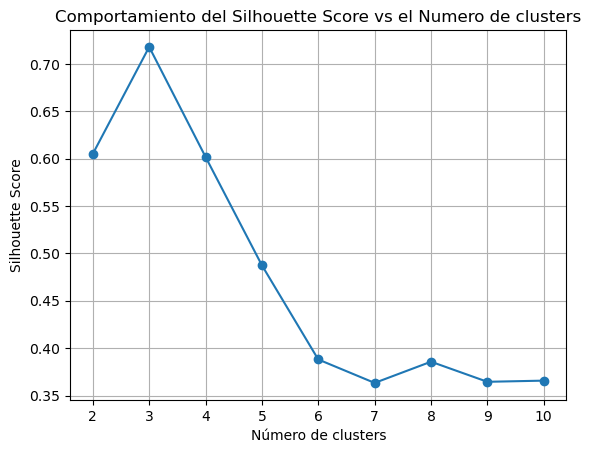

In [20]:
silhouette_plot(data_blobs, 2, 10)

En este caso se tiene un comportamiento similar al observado en los datos de nuestro problema, pero con valores más altos para el coeficiente de la silueta (con un pico de 0.7). Al igual que con el método del codo, podemos determinar que el mejor _k_ para los datos generados con `make_blobs()` es 3.

## 7. Interpretación de los grupos resultantes del mejor modelo

Con el mejor valor de _k_, primero ejecutaremos el algoritmo de KMeans:

In [21]:
pipe.set_params(model__n_clusters=3)
pipe.fit(data)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=77))])

In [22]:
labels = pipe['model'].labels_
indexes, values = np.unique(labels, return_counts=True)
{indexes[i]: values[i] for i in range(len(indexes))}

{0: 1042, 1: 5, 2: 15}

([<matplotlib.axis.XTick at 0x185b54210>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

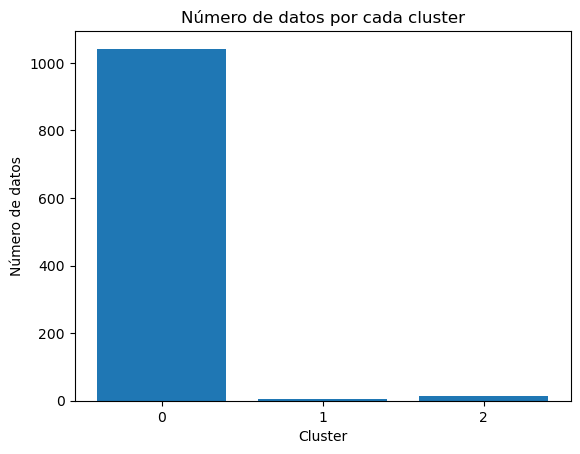

In [23]:
rects = plt.bar(indexes, values)
plt.xlabel('Cluster')
plt.ylabel('Número de datos')
plt.title('Número de datos por cada cluster')
plt.xticks(indexes)

In [24]:
centroids_array = pipe['model'].cluster_centers_
centroids = pd.DataFrame(centroids_array, columns=data.columns)
centroids

,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels
0,-0.084271,-0.099840,-0.109597,-0.073266,-0.075007,-0.017093,-0.057505
1,13.818025,6.324618,2.110446,14.303251,-0.253499,0.312734,2.388491
2,1.248006,4.827338,6.909842,0.321788,5.294976,1.083155,3.198517


Como los centroides están escalados porque incluimos en el pipeline. Para obtener valores que sean interpretables con los rangos iniciales de los datos, utilizaremos la función `inverse_transform()`

In [25]:
centroids_transformed = scaler.inverse_transform(centroids)
centroids_transformed = pd.DataFrame(centroids_transformed, columns=data.columns)
centroids_transformed

,Solid Fuel,Liquid Fuel,Gas Fuel,Cement,Gas Flaring,Per Capita,Bunker fuels
0,6.804095e+03,8138.613244,4797.606526,904.774472,219.887716,1.392908,1179.880998
1,1.979362e+06,321552.200000,76249.600000,300124.800000,0.000000,1.974000,12229.400000
2,1.958371e+05,248508.266667,230718.000000,9127.066667,6835.266667,3.331333,15888.600000


## 8. Arbol de decisión Explicabilidad

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [27]:
dt_lables=pd.DataFrame(labels,columns=['Grupos'])
data_labels= pd.merge(data, dt_lables,
               left_index=True,
               right_index=True,
               how = 'left')

In [28]:
scaler = StandardScaler()
numeric_features = [0,1, 2,3 ,4, 5, 6]
column_transformer = ColumnTransformer(
    transformers=[
        ("num", scaler, numeric_features)
    ]
)
simple_imputer = SimpleImputer(strategy='most_frequent')
steps = [
    ("imputer",simple_imputer),
    ("transformer",column_transformer)
]

In [29]:
pipeline = Pipeline(steps)

In [30]:
x_train = data_labels.drop(['Grupos'],axis=1)
y_train = data_labels['Grupos']
columns = x_train.columns
x_train_transformed = pipeline.fit_transform(x_train)
x_train_transformed = pd.DataFrame(x_train_transformed, columns=columns)

Con el fin de utilizar de generar explicabilidad del los grups, se hace uso del arbol de decicion solo con propósitos explicativos.

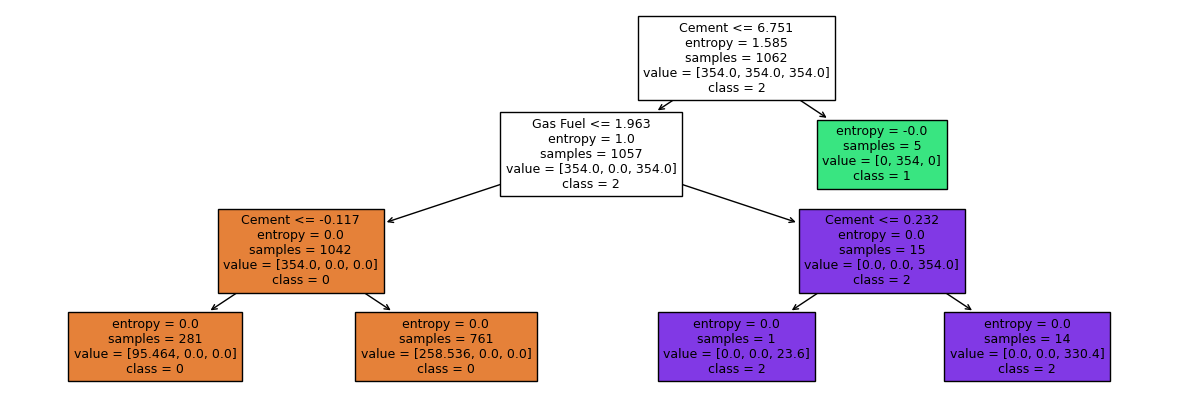

In [31]:
deciscion_tree_prueba = DecisionTreeClassifier(criterion = 'entropy', max_depth = 4 ,class_weight = 'balanced', random_state = 0, min_samples_split = 3)
deciscion_tree_prueba.fit(x_train_transformed, y_train)
plt.figure(figsize=(15,5))
tree = plot_tree(deciscion_tree_prueba, feature_names=list(columns), class_names=['0','1','2'], filled=True, fontsize=9)

### 9. Preguntas
- **¿Cuál es el valor del coeficiente de silueta para el número de grupos seleccionado?** El valor el coeficiente es de 0.717815068977272

- **Con base en el mejor valor del coeficiente de silueta ¿consideras que el rendimiento del modelo es adecuado? Si no es así, ¿cómo podrían mejorarse los resultados?**  Debido a que se eliminaron dos variables que no se consideran importatntes, tal vez realizando una transformacion es esas variables categoricas pueda ayudar a ingrementar el coeficinte.

- **¿Cuáles son las reglas que caracterizan cada grupo con base en el árbol explicativo? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema**.<br>
>Si  -0.117 <= Cement <= 6.751 y Gas Fuel <= 1.963, entonces es del Grupo 0.<br>
>Si Cement > 6.751, entonces es del Grupo 1.<br>
>Si Cement <= 6.751 y Gas Fuel > 1.963, entonces es del Grupo 2.<br>

- **En este contexto y con base en las características del problema ¿Qué otras técnicas de evaluación consideras que podrías aplicar?**  Se podria aplicar otro metodo de agrupacion como K-Medoid que no utiliza la media como medida de evaluacion sino la mediana y comprar con los dos metodos.

## Cierre
---
*Creado por: Alejandra Ossa Yepes*   
*Versión de: Septiembre 30, 2022*  
*Universidad de los Andes*    